### This notebook predicts who will survive on the titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

df_train = pd.read_csv('/home/melgazar9/Downloads/titanic_train.csv')
df_test = pd.read_csv('/home/melgazar9/Downloads/titanic_test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Find the columns that have null values and show how many

In [2]:
passenger_id_test = df_test['PassengerId']
df_train.isnull().sum()[df_train.isnull().sum()>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

#### Reorder df_train to make Survived the last column

In [3]:
df_train = df_train[['PassengerId', 'Pclass', 'Name', 'Sex',
                    'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
                    'Embarked', 'Survived']]

# Assign X (data) and y (target)
X = df_train.drop('Survived', axis=1)
y = df_train.Survived

#### Look at the target distribution
Slightly imbalanced

In [5]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### Look at the distribution of Age, Cabin, and Embarked to see how we can fill null values

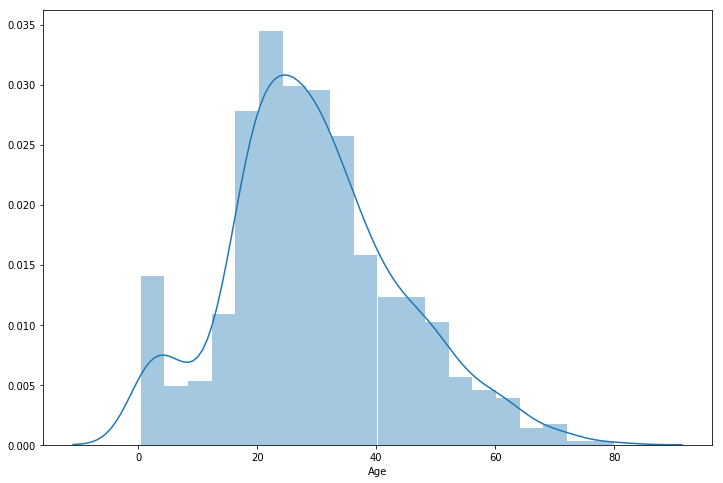

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(X['Age'].dropna())

In [7]:
X['Cabin'].dropna().value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
F33                3
F2                 3
E101               3
C22 C26            3
D                  3
E8                 2
B57 B59 B63 B66    2
B35                2
C126               2
C78                2
B28                2
F G73              2
E24                2
B5                 2
C2                 2
E25                2
D33                2
D36                2
F4                 2
E67                2
C93                2
B49                2
C124               2
C92                2
C125               2
D26                2
B20                2
                  ..
C111               1
C54                1
E50                1
C106               1
C47                1
E12                1
B94                1
D48                1
B37                1
C95                1
B78                1
A10                1
C101               1
A24                1
C90                1
C46                1
D49          

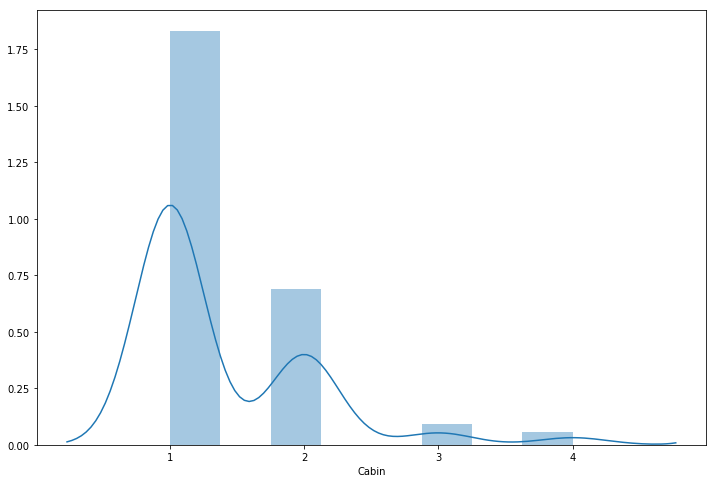

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(X['Cabin'].dropna().value_counts())

#### Since most cabin numbers are null, I will impute null values by randomly selecting values from the existing values

In [9]:
random_cabin_choices = [np.random.choice(X['Cabin'].dropna()) for i in range(X['Cabin'].isnull().sum())]

In [10]:
X['Cabin'] = X['Cabin'].fillna(pd.Series(np.random.choice(random_cabin_choices, size=len(X['Cabin'].index))))
df_test['Cabin'] = df_test['Cabin'].fillna(pd.Series(np.random.choice(random_cabin_choices, size=len(df_test['Cabin'].index))))
X['Cabin'].head()

0     D20
1     C85
2     B49
3    C123
4     F38
Name: Cabin, dtype: object

In [11]:
X['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

#### Fill Embarked column with most frequent -> S

In [12]:
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].value_counts().idxmax())
df_test['Embarked'] = df_test['Embarked'].fillna(df_test['Embarked'].value_counts().idxmax())

#### There is 1 missing value in df_test['Fare'] -> fill it with median

In [13]:
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)

In [15]:
numerical_cols = list(df_train.dtypes[df_train.dtypes != 'object'].index)
numerical_cols

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']

In [16]:
non_numerical_cols = [set(X.columns) - set(numerical_cols)]
non_numerical_cols

[{'Cabin', 'Embarked', 'Name', 'Sex', 'Ticket'}]

#### Categorize non-numeric columns

In [17]:
for field_name, dtype in X.dtypes[X.dtypes == 'object'].items():
    print(field_name)
    X[field_name] = pd.Series(pd.Categorical(X[field_name]).codes)
    
print('\n')
for field_name, dtype in df_test.dtypes[df_test.dtypes == 'object'].items():
    print(field_name)
    df_test[field_name] = pd.Series(pd.Categorical(df_test[field_name]).codes)

Name
Sex
Ticket
Cabin
Embarked


Name
Sex
Ticket
Cabin
Embarked


In [18]:
X.get_dtype_counts()

float64    2
int16      3
int64      4
int8       2
dtype: int64

In [19]:
df_test.get_dtype_counts()

float64    2
int16      3
int64      4
int8       2
dtype: int64

#### We can see below the Age column is slightly right skewed. A good choice for filling null values may be by comparing age with another variable. This may make it easier to predict age.

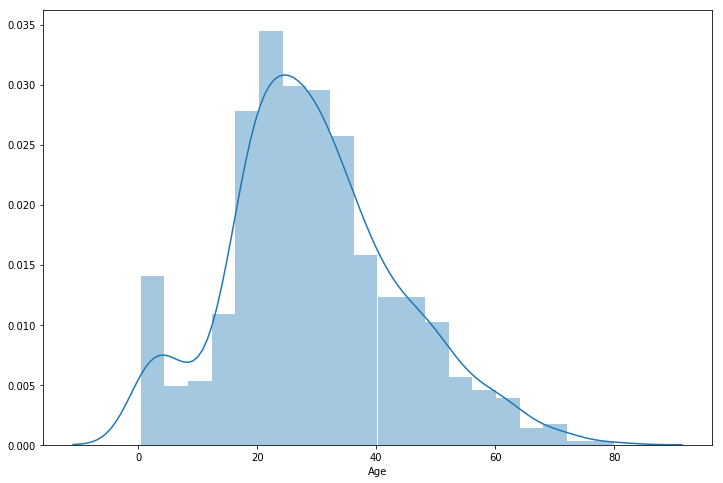

In [20]:
plt.figure(figsize=(12,8))
sns.distplot(X['Age'].dropna())

#### The Age column has decimals in there... To simplify things I'll round decimals down to integers

In [21]:
X['Age'] = X['Age'].apply(np.floor)
X['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

#### Now plot the age distribution

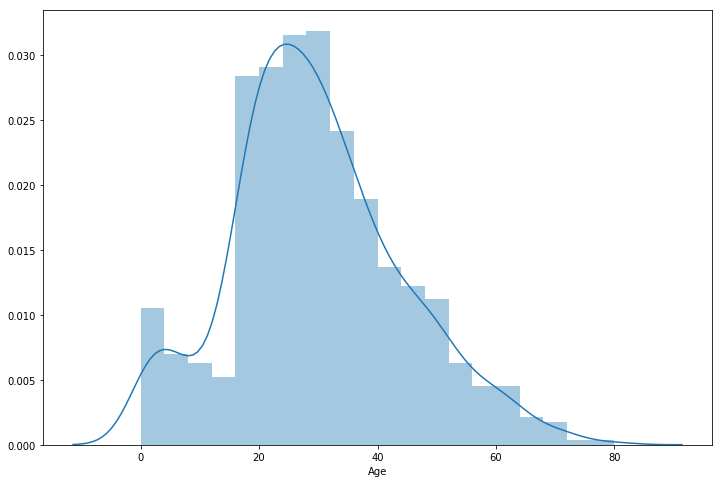

In [22]:
plt.figure(figsize=(12,8))
sns.distplot(X['Age'].dropna())

In [23]:
X['Age'].describe()

count    714.000000
mean      29.679272
std       14.536483
min        0.000000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

#### There is only a slight correlation between age and Pclass, but that might be enough to impute age with reasonable values
Pclass is the closest linear correlation to Age (negatively correlated)

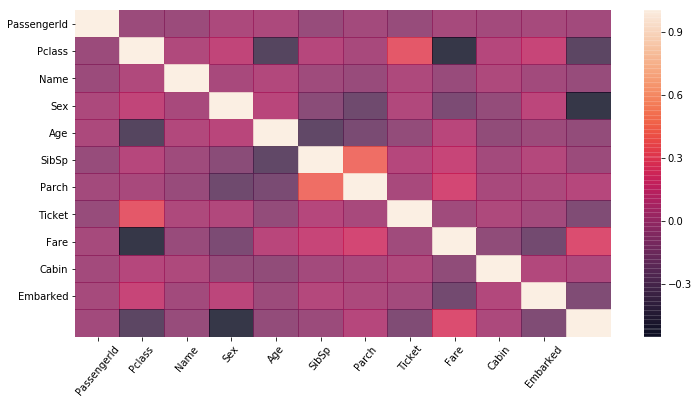

In [25]:
figure = plt.figure(figsize=(12,6))
sns.heatmap(pd.concat([X, y], axis=1).corr(),
            xticklabels=X.corr().columns.values,
            yticklabels=X.corr().columns.values, alpha=.8)
plt.xticks(rotation=50)
plt.show()

#### Bucketize age so we can see a relationship between age bucket and Pclass

In [26]:
age_buckets = pd.qcut(X['Age'], q=10)
age_buckets.name = 'age_bucket'
age_buckets.value_counts()

(31.8, 36.0]      92
(14.0, 19.0]      86
(41.0, 50.0]      78
(-0.001, 14.0]    78
(22.0, 25.0]      70
(19.0, 22.0]      67
(50.0, 80.0]      64
(28.0, 31.8]      64
(25.0, 28.0]      63
(36.0, 41.0]      52
Name: age_bucket, dtype: int64

In [27]:
X = pd.concat([X, age_buckets], axis=1)
X['age_bucket'].fillna(X['age_bucket'].value_counts().idxmax(), inplace=True)
grouped = X.groupby(['Pclass','age_bucket']).count()

### The plot below shows some ideas for how we can impute null values
Passengers in Pclass 2 tend to be between 22 and 36 <br>
Passengers in Pclass 3 tends to skew right -> Ages between 0 and 22 years old <br>
Passengers in Pclass 1 tend to be between 31 and 80, with a left skew on ages between 40 and 80

In [28]:
print('Pclass1 age mean', (31+80)/2)
print('Pclass2 age mean', (22+36)/2)
print('Pclass3 age mean', 22/2)

Pclass1 age mean 55.5
Pclass2 age mean 29.0
Pclass3 age mean 11.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

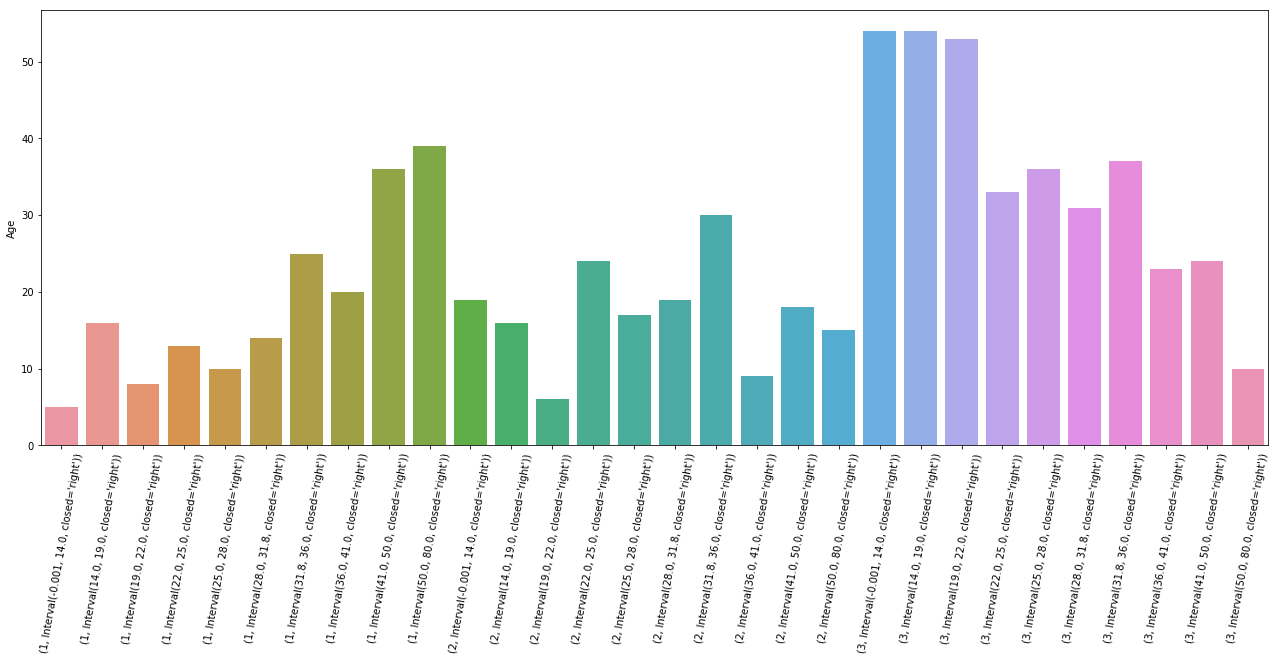

In [29]:
plt.figure(figsize=(22,8))
sns.barplot(x=grouped.index, y=grouped['Age'])
plt.xticks(rotation=80)

In [30]:
def impute_ages(df):
    
    df.loc[df['Pclass'] == 1, 'Age'] = 55
    df.loc[df['Pclass'] == 2, 'Age'] = 29
    df.loc[df['Pclass'] == 3, 'Age'] = 11
    return df['Age']

X['Age'] = impute_ages(X)
df_test['Age'] = impute_ages(df_test)
X.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
age_bucket     0
dtype: int64

#### One-hot encode Age, Pclass, SibSp, Parch, and Embarked features

In [31]:
X = pd.get_dummies(X, columns=['SibSp', 'Parch', 'Sex', 'Embarked', 'Pclass'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['SibSp', 'Parch', 'Sex', 'Embarked', 'Pclass'], drop_first=True)

#### Drop the name and passenger_id columns since they are irrelevant and may lead to overfitting

In [32]:
X.drop(['Name', 'PassengerId'], axis=1, inplace=True)

#### Check the possible features (the features in X must be the same features in df_test!)

In [33]:
possible_features = [col for col in X.columns if col in df_test.columns]
X = X[possible_features]
df_test = df_test[possible_features]

len(X.columns), len(df_test.columns)

(21, 21)

In [35]:
X.head()

,Age,Ticket,Fare,Cabin,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,...,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Sex_1,Embarked_1,Embarked_2,Pclass_2,Pclass_3
0,11.0,523,7.2500,96,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,55.0,596,71.2833,81,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.0,669,7.9250,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,55.0,49,53.1000,55,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,11.0,472,8.0500,143,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1


### Feature Engineering and more EDA

#### Let's look at the relationship between survived and ticket number

In [36]:
X['Ticket'].value_counts(), len(X)

(568    7
 80     7
 333    7
 337    6
 566    6
 249    6
 621    5
 480    5
 194    4
 95     4
 610    4
 83     4
 329    4
 395    4
 33     4
 574    4
 676    4
 37     4
 488    4
 155    3
 634    3
 556    3
 237    3
 613    3
 571    3
 588    3
 608    3
 423    3
 307    3
 469    3
       ..
 352    1
 353    1
 354    1
 355    1
 356    1
 357    1
 358    1
 359    1
 360    1
 361    1
 362    1
 363    1
 364    1
 366    1
 381    1
 367    1
 368    1
 369    1
 370    1
 371    1
 372    1
 373    1
 374    1
 375    1
 376    1
 598    1
 378    1
 379    1
 380    1
 340    1
 Name: Ticket, Length: 681, dtype: int64, 891)

#### Use Chi-Squared test to test if the values are independent
Assume null hypothesis is the variables are independent and alpha=.05 <br>
Since the p-value is significantly less than alpha, we reject the null hypothesis, hence we can assume the variables are not independent

In [37]:
from scipy.stats import chi2_contingency, spearmanr

table = pd.crosstab(X['Ticket'], y)

chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi2:', chi2)
print('P-Value:', p)
print('Dof:', dof)
print('Expected:', expected)

Chi2: 766.5697029458893
P-Value: 0.01152729601163775
Dof: 680
Expected: [[1.84848485 1.15151515]
 [1.84848485 1.15151515]
 [1.23232323 0.76767677]
 ...
 [0.61616162 0.38383838]
 [0.61616162 0.38383838]
 [1.23232323 0.76767677]]


#### Since the variables are unlikely independent, they are correlated in some way, which means we can use Spearmans Rank Correlation
There seems to be a small correlation between the two categorical variables, which is basically what the heatmap said earlier

In [38]:
spr_coeff, pvalue = spearmanr(X['Ticket'], y)
print('Spearmans Correlation:', spr_coeff)
print('p-value:', pvalue)

Spearmans Correlation: -0.16335393954678754
p-value: 9.478243074146128e-07


In [39]:
grouped = pd.concat([X, y], axis=1).groupby(['Ticket', 'Survived']).count()
grouped.head()

Age  Fare  Cabin  SibSp_1  SibSp_2  SibSp_3  SibSp_4  \
Ticket Survived                                                         
0      1           3     3      3        3        3        3        3   
1      0           1     1      1        1        1        1        1   
       1           2     2      2        2        2        2        2   
2      0           2     2      2        2        2        2        2   
3      1           1     1      1        1        1        1        1   

                 SibSp_5  SibSp_8  Parch_1  Parch_2  Parch_3  Parch_4  \
Ticket Survived                                                         
0      1               3        3        3        3        3        3   
1      0               1        1        1        1        1        1   
       1               2        2        2        2        2        2   
2      0               2        2        2        2        2        2   
3      1               1        1        1        1        1        1   

                 Parch_5  Parch_6  Sex_1  Embarked_1  Embarked_2  Pclass_2  \
Ticket Survived                                                              
0      1               3        3      3           3           3         3   
1      0               1        1      1           1           1         1   
       1               2        2      2           2           2         2   
2      0               2        2      2           2           2         2   
3      1               1        1      1           1           1         1   

                 Pclass_3  
Ticket Survived            
0      1                3  
1      0                1  
       1                2  
2      0                2  
3      1                1

#### Pairplot of the full dataframe
Clearly there are many non-linear relationships, but this is a bit much to look at

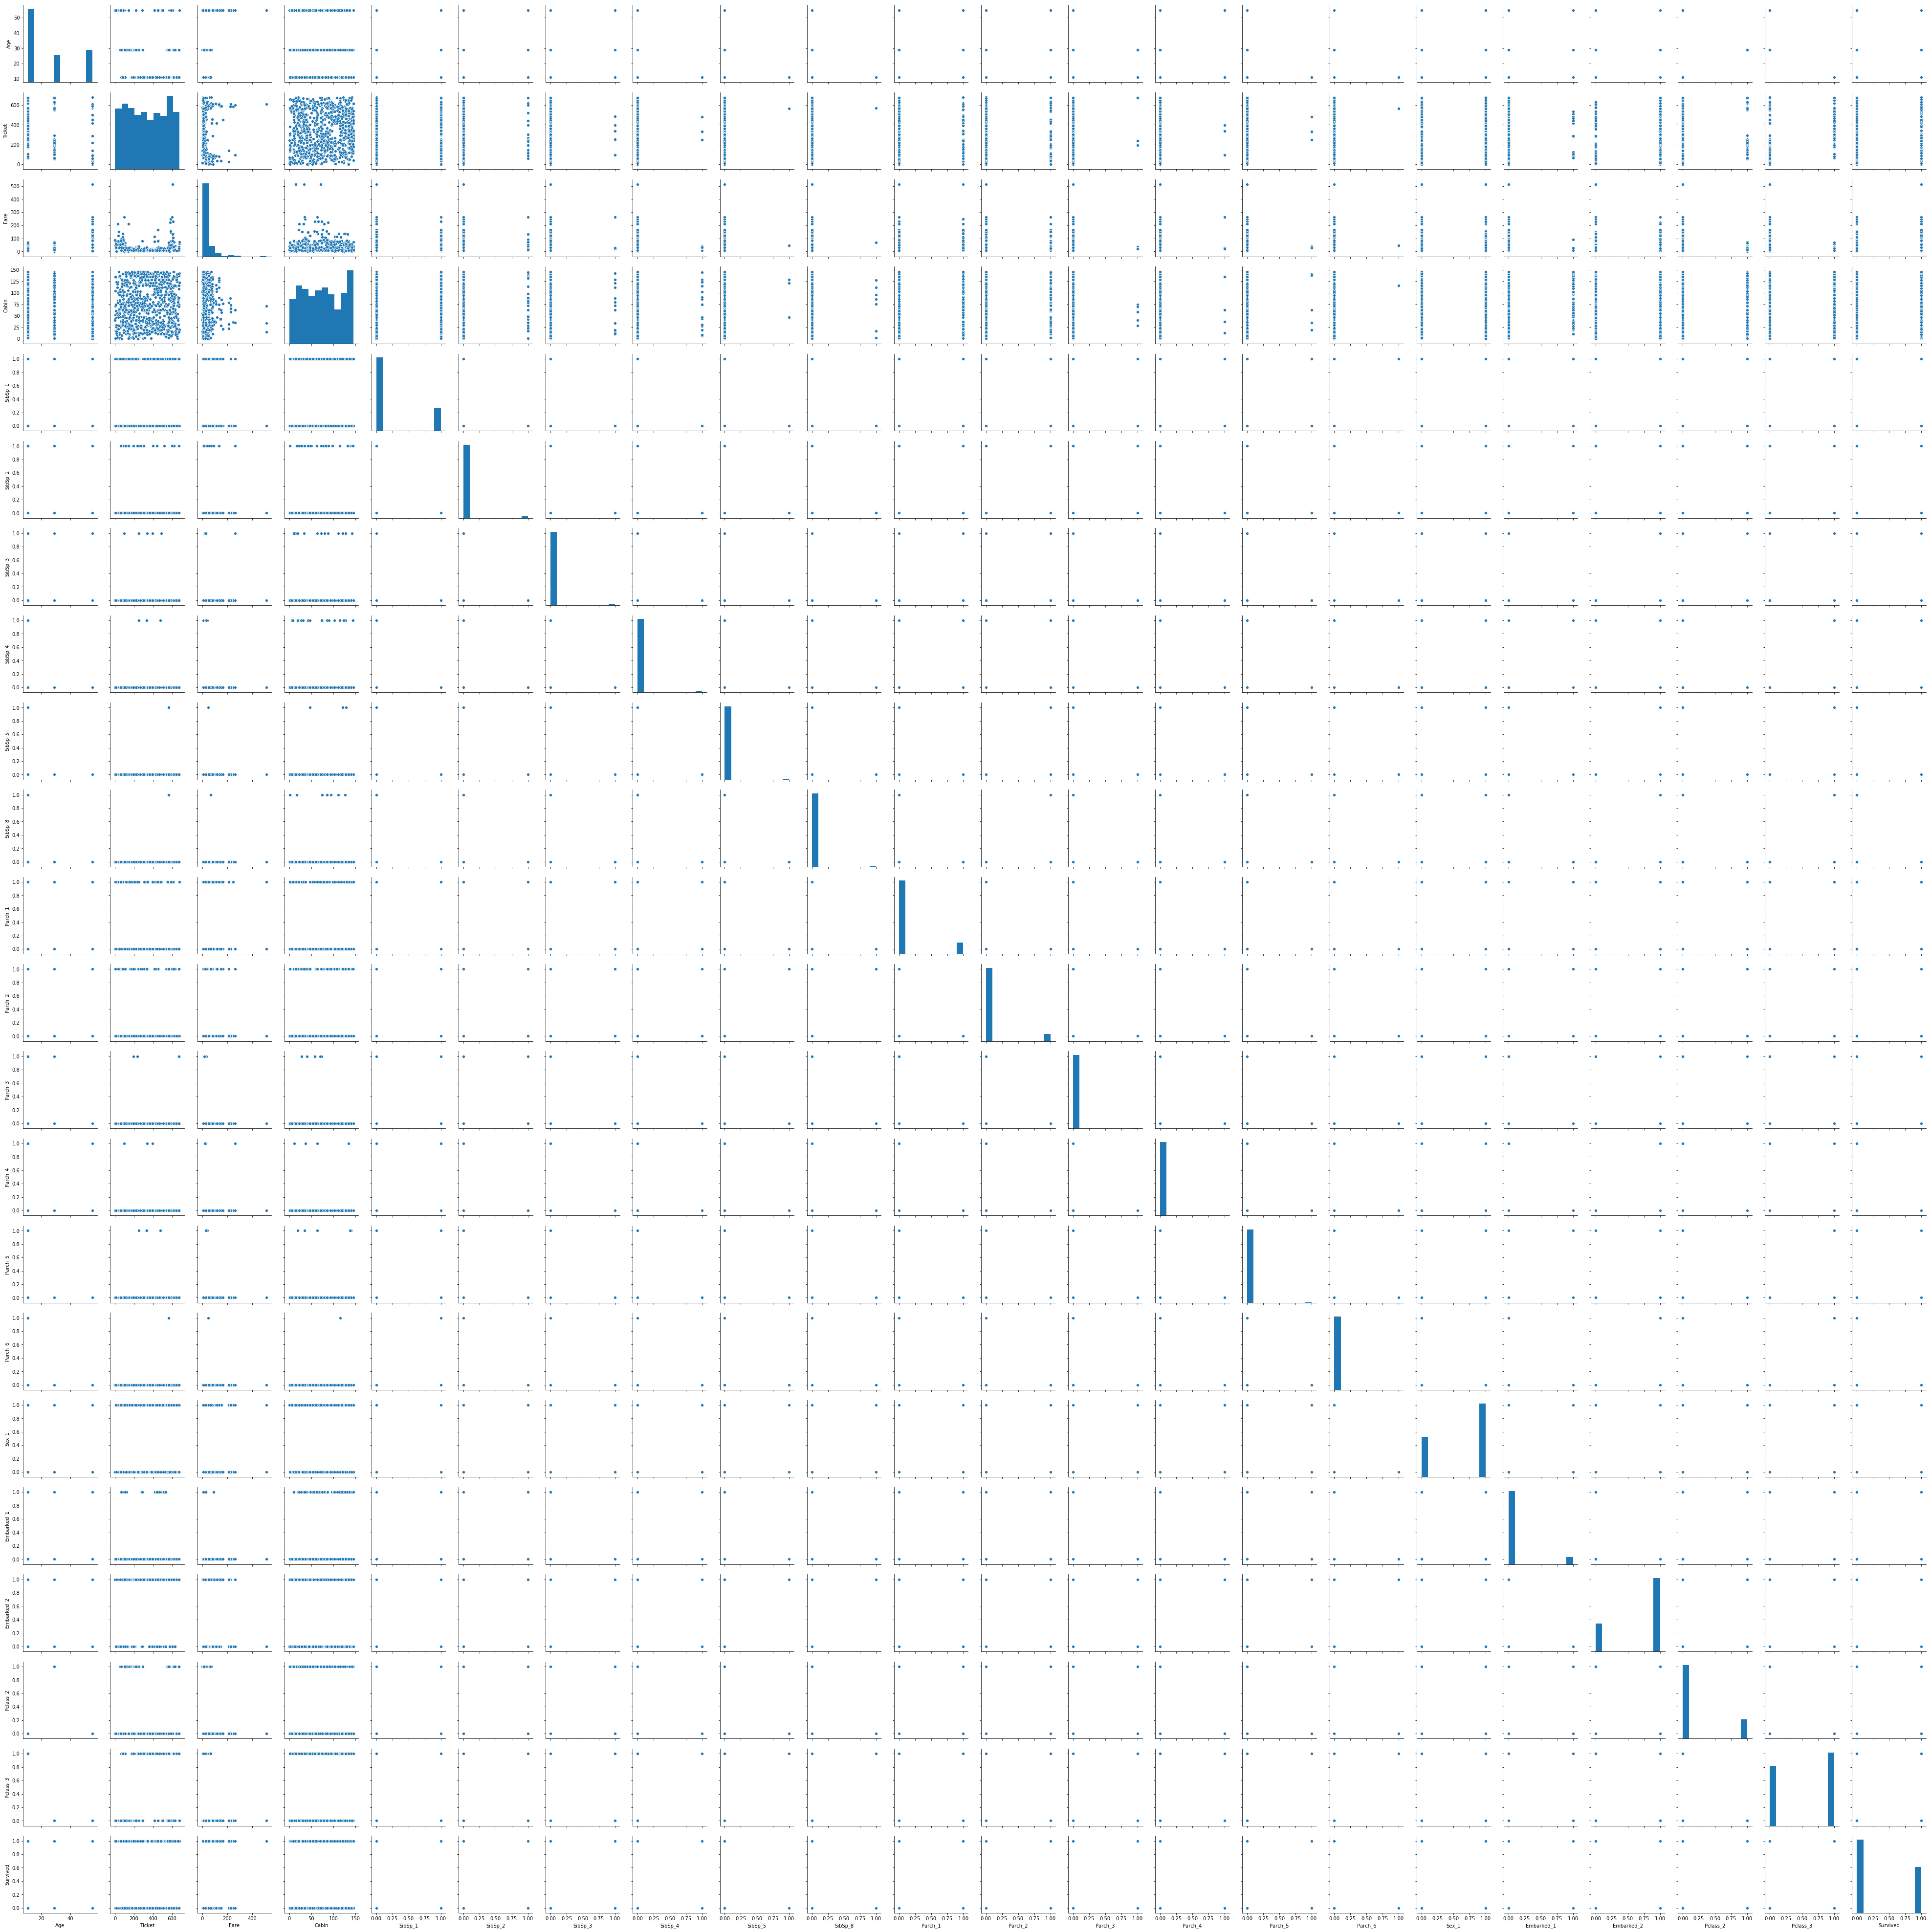

In [40]:
sns.pairplot(pd.concat([X,y], axis=1))

### Machine Learning

#### Train Test Split

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
len(X_train), len(X_test)

(668, 223)

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

/home/melgazar9/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/melgazar9/anaconda3/envs/lgbm-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int16, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/melgazar9/anaconda3/envs/lgbm-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int16, float64 were all converted to float64 by StandardScaler.
  """


#### Fit a dummy classifier and compare the classifiers performance to other prototyped models

In [43]:
from sklearn.dummy import DummyClassifier

# Define a dummy model for a benchmark that predicts the majority class every time
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X, y)
y_predict_dummy = dummy_majority.fit(X, y)

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

count_majorities = y.value_counts()  # 0 is most frequent, i.e. most people don't get bound

y_dummy_train = pd.Series(y.value_counts().idxmax(), index=y_train.index)
y_dummy_test = pd.Series(y.value_counts().idxmax(), index=y_test.index)


# Find classification report for dummy classifier
print('Dummy Classification Train Accuracy: ', accuracy_score(y_dummy_train, y_train))
print('Dummy Classification Report for training set: \n ', classification_report(y_dummy_train, y_train))
print('Dummy Classification Test Accuracy: ', accuracy_score(y_dummy_test, y_test))
print('Dummy Classification Report for test set: \n ', classification_report(y_dummy_test, y_test))

Dummy Classification Train Accuracy:  0.6167664670658682
Dummy Classification Report for training set: 
                precision    recall  f1-score   support

           0       1.00      0.62      0.76       668
           1       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62       668
   macro avg       0.50      0.31      0.38       668
weighted avg       1.00      0.62      0.76       668

Dummy Classification Test Accuracy:  0.6143497757847534
Dummy Classification Report for test set: 
                precision    recall  f1-score   support

           0       1.00      0.61      0.76       223
           1       0.00      0.00      0.00         0

   micro avg       0.61      0.61      0.61       223
   macro avg       0.50      0.31      0.38       223
weighted avg       1.00      0.61      0.76       223



#### Compare how each model performs without any tuning. This will give an idea about which model to start with

In [45]:
# Compare models right away and see which performs best/worst
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')

models = []
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('LGBM', LGBMClassifier(device='gpu')))
models.append(('CatBoost', CatBoostClassifier(task_type='GPU', verbose=False)))

results = []
names = []
for name, model, in models:
    kfold = KFold(n_splits=5, random_state=0)
    cv_result = cross_val_score(model, X_train, y_train, 
                                 cv=5, scoring='accuracy')

    results.append(cv_result)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_result.mean(), cv_result.std())
    print(msg)

AB: 0.781479 (0.035092)
GBM: 0.800927 (0.014992)
RF: 0.782926 (0.014294)
ET: 0.781456 (0.026290)
LR: 0.808401 (0.030423)
KNN: 0.642054 (0.040800)
SVC: 0.658695 (0.012514)
XGB: 0.797774 (0.028905)
LGBM: 0.793386 (0.017809)
CatBoost: 0.800815 (0.043661)


#### Look at overfitting/underfitting based on the train/test accuracy scores for all of these models
Below you can see Logistic Regression generalizes the best out of the box. <br>
SVM can do very well on small data sets but require normalization and lots of tuning. Computation can also be slow <br>
The tree classifiers overfit out of the box, but with tuning and regularization they can be very powerful

In [46]:
def calc_init_results(X_train, X_test, y_train, y_test, model):
    
    model = model.fit(X_train, y_train)
    
    train_score = accuracy_score(model.predict(X_train), y_train)
    test_score = accuracy_score(model.predict(X_test), y_test)
    
    print(type(model).__name__, 'Train Accuracy Score:', train_score)
    print(type(model).__name__, 'Test Accuracy Score:', test_score)
    
    return train_score, test_score

models = [AdaBoostClassifier(), LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier(),
          ExtraTreesClassifier(), KNeighborsClassifier(), SVC(), XGBClassifier(), LGBMClassifier(), 
          CatBoostClassifier(verbose=False)]


train_results_raw = []
test_results_raw = []

train_results_scaled = []
test_results_scaled = []

print('Not Scaled Results:')
for m in models:
    result = calc_init_results(X_train, X_test, y_train, y_test, m)
    train_results_raw.append(result[0])
    test_results_raw.append(result[1])
    print('\n')
    
print('Scaled Results:')
for m in models:
    result = calc_init_results(X_train_scaled, X_test_scaled, y_train, y_test, m)
    train_results_scaled.append(result[0])
    test_results_scaled.append(result[1])
    print('\n')
    


Not Scaled Results:
AdaBoostClassifier Train Accuracy Score: 0.8263473053892215
AdaBoostClassifier Test Accuracy Score: 0.820627802690583


LogisticRegression Train Accuracy Score: 0.8188622754491018
LogisticRegression Test Accuracy Score: 0.7892376681614349


GradientBoostingClassifier Train Accuracy Score: 0.9131736526946108
GradientBoostingClassifier Test Accuracy Score: 0.8161434977578476


RandomForestClassifier Train Accuracy Score: 0.9790419161676647
RandomForestClassifier Test Accuracy Score: 0.7892376681614349


ExtraTreesClassifier Train Accuracy Score: 1.0
ExtraTreesClassifier Test Accuracy Score: 0.757847533632287


KNeighborsClassifier Train Accuracy Score: 0.7619760479041916
KNeighborsClassifier Test Accuracy Score: 0.6143497757847534


SVC Train Accuracy Score: 0.9820359281437125
SVC Test Accuracy Score: 0.6591928251121076


XGBClassifier Train Accuracy Score: 0.8907185628742516
XGBClassifier Test Accuracy Score: 0.8071748878923767


LGBMClassifier Train Accuracy Score: 

In [47]:
[type(m).__name__ for m in models]

['AdaBoostClassifier',
 'LogisticRegression',
 'GradientBoostingClassifier',
 'RandomForestClassifier',
 'ExtraTreesClassifier',
 'KNeighborsClassifier',
 'SVC',
 'XGBClassifier',
 'LGBMClassifier',
 'CatBoostClassifier']

In [48]:
raw_results = pd.DataFrame(train_results_raw).rename(columns={0:'Train Results Raw'})
raw_results['Test Results Raw'] = test_results_raw
raw_results['model'] = [type(m).__name__ for m in models]
raw_results = raw_results.groupby('model').first()
raw_results

,Train Results Raw,Test Results Raw
model,,
AdaBoostClassifier,0.826347,0.820628
CatBoostClassifier,0.901198,0.802691
ExtraTreesClassifier,1.000000,0.757848
GradientBoostingClassifier,0.913174,0.816143
KNeighborsClassifier,0.761976,0.614350
LGBMClassifier,0.986527,0.807175
LogisticRegression,0.818862,0.789238
RandomForestClassifier,0.979042,0.789238
SVC,0.982036,0.659193


#### Non-scaled bar chart

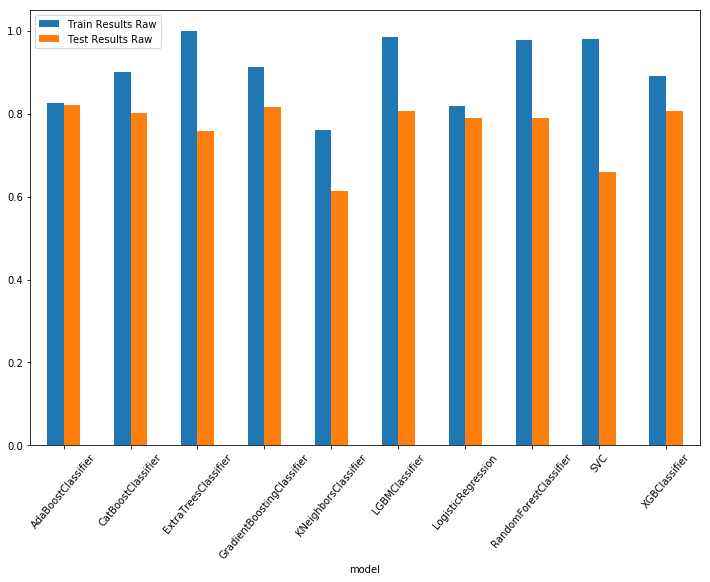

In [49]:
raw_results.plot(kind='bar', figsize=(12,8), rot=50)

In [50]:
scaled_results = pd.DataFrame(train_results_scaled).rename(columns={0:'Train Results scaled'})
scaled_results['Test Results scaled'] = test_results_scaled
scaled_results['model'] = [type(m).__name__ for m in models]
scaled_results = scaled_results.groupby('model').first()
scaled_results

,Train Results scaled,Test Results scaled
model,,
AdaBoostClassifier,0.826347,0.820628
CatBoostClassifier,0.901198,0.807175
ExtraTreesClassifier,1.000000,0.744395
GradientBoostingClassifier,0.913174,0.816143
KNeighborsClassifier,0.833832,0.744395
LGBMClassifier,0.989521,0.793722
LogisticRegression,0.815868,0.793722
RandomForestClassifier,0.985030,0.771300
SVC,0.836826,0.789238


#### Scaled bar chart

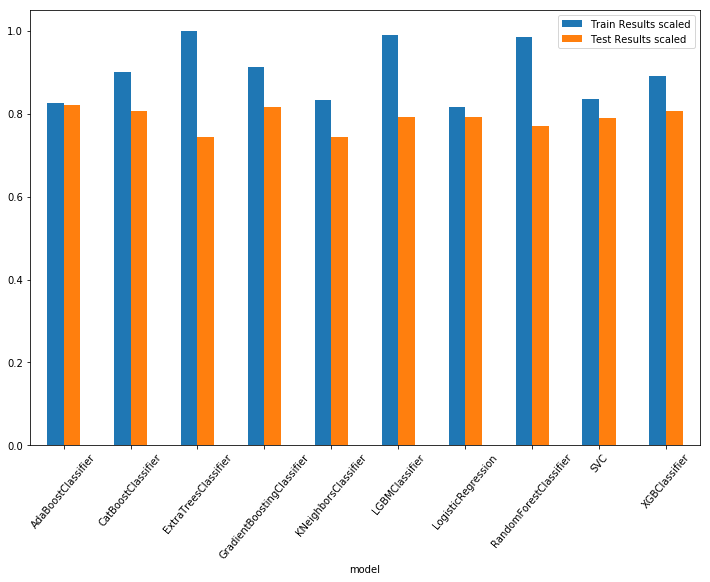

In [51]:
scaled_results.plot(kind='bar', rot=50, figsize=(12,8))

#### I will start by tuning Logistic Regression since it started out generalizing very well out of the box. I will test more models later.
I will add cross validation while tuning this model

In [52]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegressionCV

In [53]:
class TrainModel():

    def __init__(self, model, X_train, y_train, X_test, y_test, 
                 need_cont_vars, plot_importances=True, predict_concatenated_array=False):

        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.need_cont_vars = need_cont_vars # if we need all variables to be continuous
        self.plot_importances = plot_importances
        self.predict_concatenated_array = predict_concatenated_array # for catboost and other models that need this

    def plot_feature_importances_traditional(self):

        super().__init__()

        features = self.X_train.columns
        try:
            importances = self.model.feature_importances_
            indices = np.argsort(importances)
            plt.figure(figsize=(12, 8))
            plt.title('Feature Importances')
            plt.barh(y=range(len(indices)), width=importances[indices], height=.5, color='c', align='center')
            plt.yticks(ticks=range(len(indices)), labels=[features[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.show()
        
        except AttributeError:
            coefs = self.model.coef_
            print('Coefs:', coefs)
            feature_importance = abs(self.model.coef_[0])
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            sorted_idx = np.argsort(feature_importance)
            pos = np.arange(sorted_idx.shape[0]) + .5

            featfig = plt.figure(figsize=(12,8))
            featax = featfig.add_subplot(1, 1, 1)
            featax.barh(pos, feature_importance[sorted_idx], align='center')
            featax.set_yticks(pos)
            featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
            featax.set_xlabel('Relative Feature Importance')

            plt.tight_layout()   
            plt.show()

        

        return

    def train_traditional_ML_model(self):

        super().__init__()

        if self.need_cont_vars == True:
            self.X_train = self.X_train.astype('float32')
            self.X_test = self.X_test.astype('float32')


        try:
            self.model.fit(self.X_train.fit, self.y_train,
                           early_stopping_rounds=5,
                           eval_metric='accuracy')
        except:
            self.model.fit(self.X_train, self.y_train)

        if self.predict_concatenated_array == False:
            print('Train Accuracy:', accuracy_score(self.model.predict(self.X_train), self.y_train))
#             print('Val Accuracy:', accuracy_score(self.model.predict(self.X_val), self.y_val))
            print('Test Accuracy:', accuracy_score(self.model.predict(self.X_test), self.y_test))

            print('Train F1:', f1_score(self.model.predict(self.X_train), self.y_train, average='weighted'))
#             print('Val F1:', f1_score(self.model.predict(self.X_val), self.y_val, average='weighted'))
            print('Test F1:', f1_score(self.model.predict(self.X_test), self.y_test, average='weighted'))

            print('Train:', classification_report_imbalanced(self.model.predict(self.X_train), self.y_train))
#             print('Val:', classification_report_imbalanced(self.model.predict(self.X_val), self.y_val))
            print('Test:', classification_report_imbalanced(self.model.predict(self.X_test), self.y_test))


        elif self.predict_concatenated_array == True:
            print('Train Accuracy:', accuracy_score(np.concatenate(self.model.predict(self.X_train)).ravel(), self.y_train))
#             print('Val Accuracy:', accuracy_score(np.concatenate(self.model.predict(self.X_val)).ravel(), self.y_val))
            print('Test Accuracy:', accuracy_score(np.concatenate(self.model.predict(self.X_test)).ravel(), self.y_test))

            print('Train F1:', f1_score(np.concatenate(self.model.predict(self.X_train)).ravel(), self.y_train, average='weighted'))
#             print('Val F1:', f1_score(np.concatenate(self.model.predict(self.X_val)).ravel(), self.y_val, average='weighted'))
            print('Test F1:', f1_score(np.concatenate(self.model.predict(self.X_test)).ravel(), self.y_test, average='weighted'))

            print('Train:', classification_report_imbalanced(np.concatenate(self.model.predict(self.X_train)).ravel(), self.y_train))
#             print('Val:', classification_report_imbalanced(np.concatenate(self.model.predict(self.X_val)).ravel(), self.y_val))
            print('Test:', classification_report_imbalanced(np.concatenate(self.model.predict(self.X_test)).ravel(), self.y_test))

        if self.plot_importances == True:
            self.plot_feature_importances_traditional()

        return self.model



Train Accuracy: 0.8158682634730539
Test Accuracy: 0.7982062780269058
Train F1: 0.8188723920577586
Test F1: 0.8026092442128174
Train:                    pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.82      0.80      0.86      0.81      0.66       447
          1       0.69      0.80      0.82      0.74      0.81      0.66       221

avg / total       0.83      0.82      0.81      0.82      0.81      0.66       668

Test:                    pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.80      0.79      0.84      0.80      0.63       152
          1       0.65      0.79      0.80      0.71      0.80      0.63        71

avg / total       0.81      0.80      0.79      0.80      0.80      0.63       223

Coefs: [[ 0.24901097 -0.20573627  0.22154696  0.06190026  0.08629313 -0.00475574
  -0.19461491 -0.12848549 -0.15294509 -0.15252831  0.11002933  0.10464255
   0.00433651 -0.16043454 -0.029665 

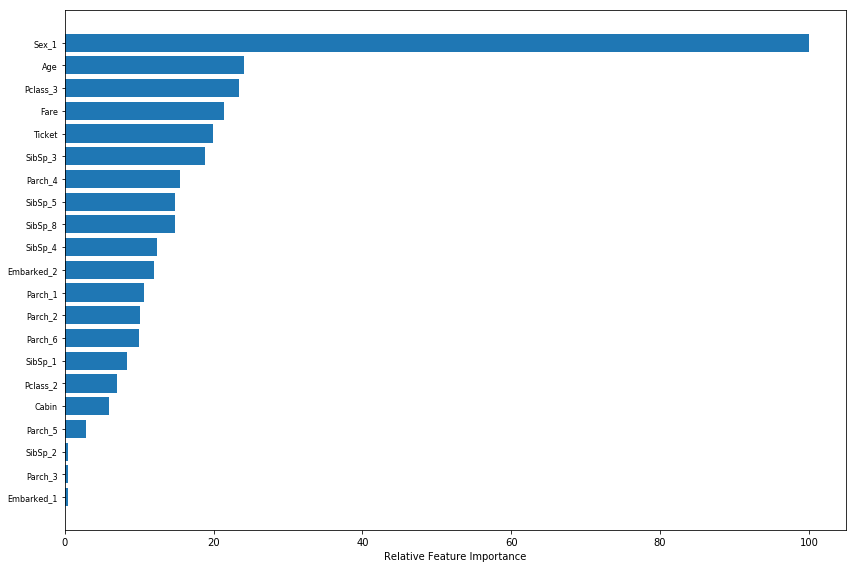

In [54]:
params = {'solver':'lbfgs', 'n_jobs':32, 'random_state':0, 'scoring':'accuracy', 'cv':5}
lr = TrainModel(LogisticRegressionCV(**params), 
                X_train_scaled, y_train, X_test_scaled, y_test, 
                need_cont_vars=False, plot_importances=True).train_traditional_ML_model()

### Plot the learning curve

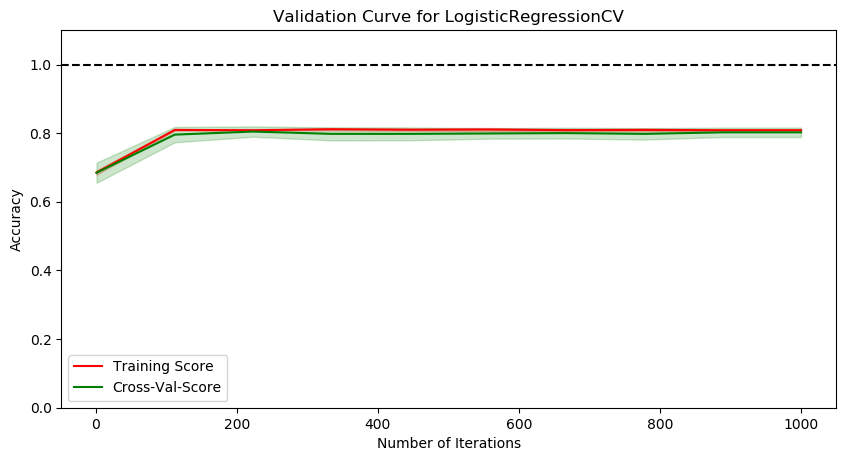

Best CV Result:  0.80472429300511 223


In [55]:
from sklearn.model_selection import validation_curve

default_params = params

iter_range = np.linspace(1, 1000, 10).astype('int')

train_scores, test_scores = validation_curve(estimator=LogisticRegressionCV(**default_params),
                                             X=X, y=y,
                                             param_name='max_iter',
                                             param_range = iter_range,
                                             cv=5,
                                             n_jobs=32,
                                             scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,5), dpi=100)

plt.title('Validation Curve for LogisticRegressionCV')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)

plt.plot(iter_range, train_scores_mean, label='Training Score', color='r')
plt.plot(iter_range, test_scores_mean, label='Cross-Val-Score', color='g')

plt.fill_between(iter_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=.2, color='r')
plt.fill_between(iter_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=.2, color='g')

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print('Best CV Result: ', test_scores_mean[i], iter_range[i])

#### Plot the precision recall curve

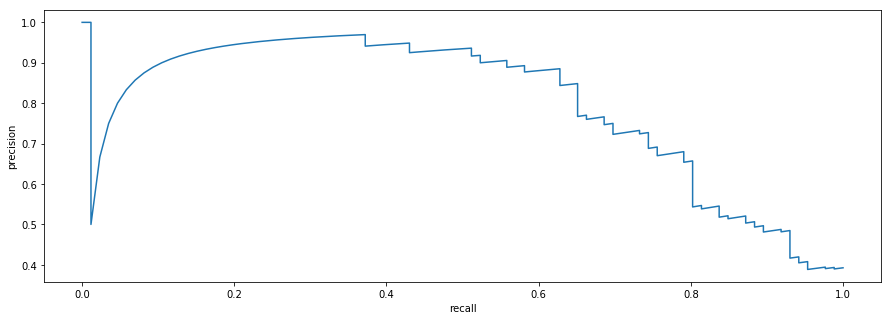

In [56]:
from sklearn.metrics import precision_recall_curve

y_score_lr = lr.decision_function(X_test_scaled)

precision, recall, threshold = precision_recall_curve(y_test, y_score_lr)

fig = plt.gcf()
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
fig.set_size_inches((15, 5))
plt.show()

#### ROC AUC Curve

<Figure size 432x288 with 0 Axes>

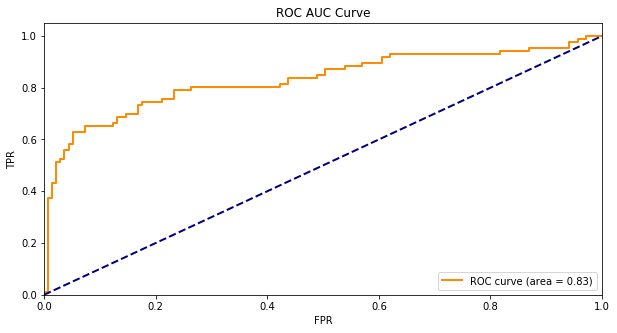

In [57]:
from sklearn.metrics import roc_curve, auc

y_score = lr.decision_function(X_test_scaled)

fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.subplots(figsize=(10, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

Explained variation per principal component: [0.12901516 0.08006147]
Train PCA Accuracy: 0.7265469061876247
Test PCA Accuracy: 0.718562874251497
Train PCA F1: 0.5958702064896755
Test PCA F1: 0.5523809523809524


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=32, penalty='l2', random_state=0,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=0)

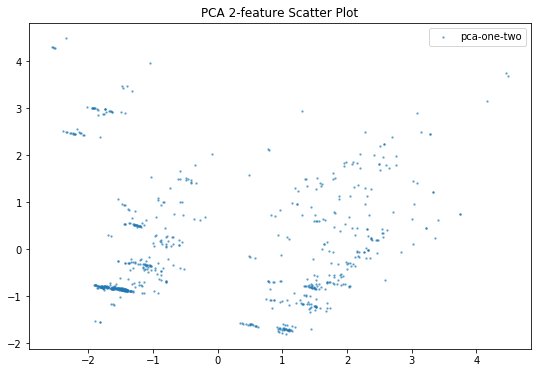

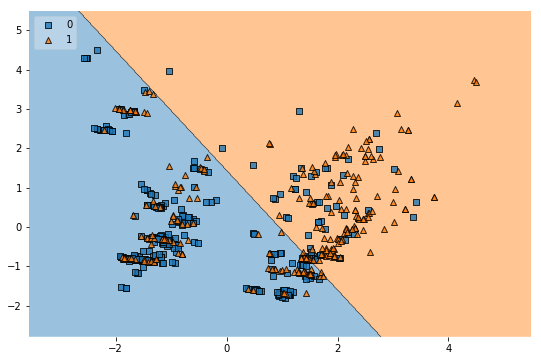

In [58]:
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions


def plot_decision_boundary_pca(X_normalized, y, model):
    
    X_pca = pd.DataFrame()

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_normalized)

    X_pca['pca-one'] = pca_result[:,0]
    X_pca['pca-two'] = pca_result[:,1] 


    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(9,6))
    plt.scatter(X_pca['pca-one'], X_pca['pca-two'], s=2, alpha=.5)
    plt.legend(['pca-one-two'])
    plt.title('PCA 2-feature Scatter Plot')
    
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, stratify=y)
    

    clf = model.fit(np.array(X_train_pca[['pca-one', 'pca-two']]), y_train_pca)
    print('Train PCA Accuracy:', accuracy_score(clf.predict(np.array(X_train_pca)), y_train_pca))
    print('Test PCA Accuracy:', accuracy_score(clf.predict(np.array(X_test_pca)), np.array(y_test_pca)))
    
    print('Train PCA F1:', f1_score(clf.predict(np.array(X_train_pca)), np.array(y_train_pca)))
    print('Test PCA F1:', f1_score(clf.predict(np.array(X_test_pca)), np.array(y_test_pca)))
    
    plt.figure(figsize=(9,6))
    plot_decision_regions(np.array(X_pca[['pca-one', 'pca-two']]), np.array(y.astype(np.int)), 
                          clf=clf,
                          legend=2)

    return clf

plot_decision_boundary_pca(X_train_scaled, y_train, LogisticRegressionCV(**params))

### Let's see how Logistic Regression does with some tuning

In [59]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'solver':['lbfgs', 'newton-cg', 'liblinear', 'saga'],
              'max_iter':[100, 500, 1000],
              'penalty':['l2']}

In [60]:
lr_rs = RandomizedSearchCV(LogisticRegressionCV(**params),
                      param_distributions=param_dist,
                      cv=5, n_iter=100,
                      scoring='accuracy').fit(X_train_scaled, y_train)
lr_rs.best_params_

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100}

Train Accuracy: 0.8143712574850299
Test Accuracy: 0.7937219730941704
Train F1: 0.8166904463683505
Test F1: 0.7971298880491705
Train:                    pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.83      0.79      0.85      0.81      0.66       440
          1       0.70      0.79      0.83      0.74      0.81      0.65       228

avg / total       0.82      0.81      0.80      0.82      0.81      0.65       668

Test:                    pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.81      0.77      0.84      0.79      0.62       149
          1       0.66      0.77      0.81      0.71      0.79      0.62        74

avg / total       0.81      0.79      0.78      0.80      0.79      0.62       223

Coefs: [[ 0.27354555 -0.25900597  0.26863863  0.05585236  0.05321302 -0.01574153
  -0.29766914 -0.19907906 -0.42497171 -0.42432733  0.14224535  0.14134143
  -0.01423786 -0.39772078 -0.0450605

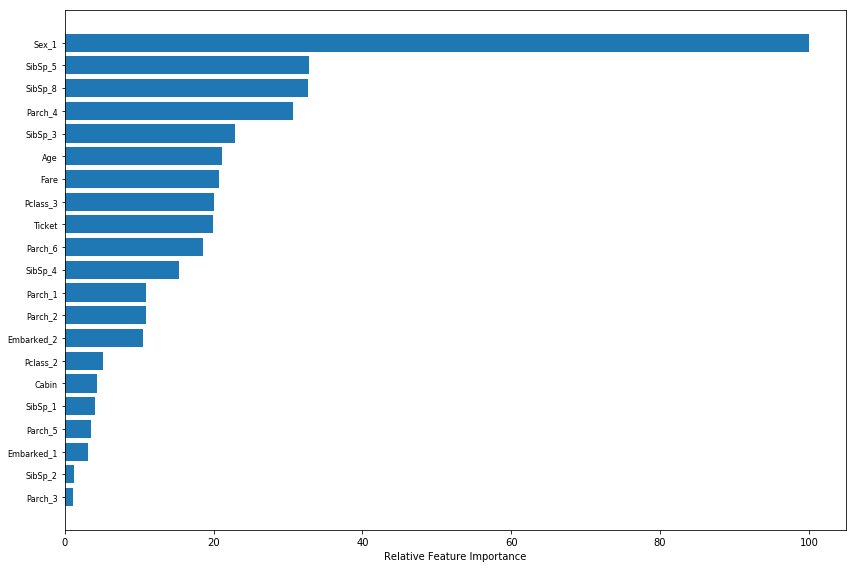

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [61]:
params = {'solver':'newton-cg', 'n_jobs':32, 'random_state':0, 'scoring':'accuracy',
          'cv':5, 'penalty':'l2','max_iter':100}
lr = TrainModel(LogisticRegressionCV(**lr_rs.best_params_), X_train_scaled, y_train, X_test_scaled, y_test, 
                need_cont_vars=False, plot_importances=True).train_traditional_ML_model()
lr

Explained variation per principal component: [0.12901516 0.08006048]
Train PCA Accuracy: 0.7285429141716567
Test PCA Accuracy: 0.7724550898203593
Train PCA F1: 0.5526315789473685
Test PCA F1: 0.6481481481481481


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=32, penalty='l2', random_state=0,
           refit=True, scoring='accuracy', solver='newton-cg', tol=0.0001,
           verbose=0)

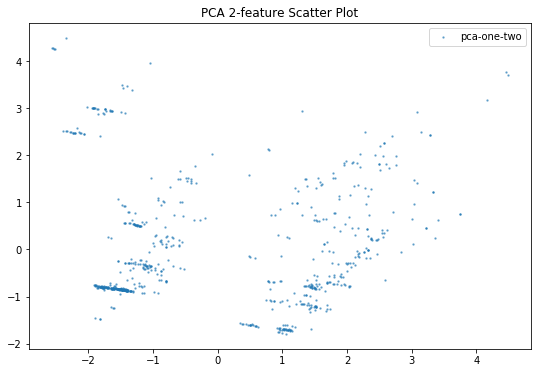

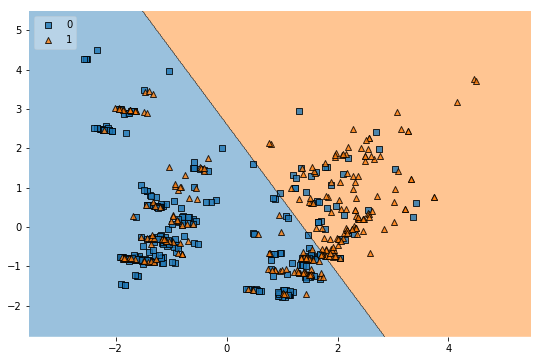

In [62]:
plot_decision_boundary_pca(X_train_scaled, y_train, LogisticRegressionCV(**params))

### Randomized search didn't really help... I'll try oversampling. 
#### I'll use SVM SMOTE here since performance has been very good in the past

In [63]:
import configparser
config = configparser.ConfigParser()
config_path = config.read('/home/melgazar9/Trading/TD/Scripts/Trading-Scripts/CL/scripts/CL_10min_TRAIN-MODEL.ini')

In [64]:
def create_oversampled_df(X_train_fit, X_val_fit, y_train, y_val, need_cont_vars=False, ratio=None):

    if config['OVERSAMPLING_PARAMS']['OverSampling_algorithm'] == 'SMOTE':
        print('Applying SMOTE...')
        sm = SMOTE(n_jobs=32, random_state=int(config['OVERSAMPLING_PARAMS']['random_state']), ratio=ratio)
    elif config['OVERSAMPLING_PARAMS']['OverSampling_algorithm'] == 'SMOTENC':
        print('Applying SMOTENC...')
        sm = SMOTENC(categorical_features=[X_train_fit.columns.get_loc(c) for c in cat_vars], n_jobs=32, k_neighbors=int(config['OVERSAMPLING_PARAMS']['kneighbors']), random_state=int(config['OVERSAMPLING_PARAMS']['random_state']))
        # print('Categorical Features:', list(df.iloc[:, [X_train_fit.columns.get_loc(c) for c in cat_vars]].columns), len([X_train_fit.columns.get_loc(c) for c in cat_vars]))
    elif config['OVERSAMPLING_PARAMS']['OverSampling_algorithm'] == 'SVMSMOTE':
        print('Applying SVMSMOTE...')
        sm = SVMSMOTE(out_step=float(config['OVERSAMPLING_PARAMS']['out_step']), n_jobs=32, sampling_strategy=config['OVERSAMPLING_PARAMS']['sampling_strategy'], random_state=int(config['OVERSAMPLING_PARAMS']['random_state']))
    elif config['OVERSAMPLING_PARAMS']['OverSampling_algorithm'] == 'RandomOverSampler':
        print('Applying RandomOverSampler...')
        sm = RandomOverSampler(config['OVERSAMPLING_PARAMS']['sampling_strategy'], random_state=int(config['OVERSAMPLING_PARAMS']['random_state']), return_indices=ast.literal_eval(config['OVERSAMPLING_PARAMS']['return_indices']))
    else:
        print('OVERSAMPLED_ON and CREATE_OVERSAMPLED_DF_ON must be set to either TRUE or FALSE')
        sys.exit()

    X_temp = pd.concat([X_train_fit, X_val_fit], axis=0)
    gc.collect()


    y_temp = pd.concat([y_train, y_val], axis=0)
    X_resampled, y_resampled = sm.fit_resample(X_temp, y_temp.ravel())
    gc.collect()
    print('Original dataset shape:', Counter(y_temp))

    X_train_oversampled = pd.DataFrame(X_resampled, columns=X_train_fit.columns).iloc[0:int(len(X_resampled)*.7)].fillna(0)
    X_val_oversampled = pd.DataFrame(X_resampled, columns=X_train_fit.columns).iloc[int(len(X_resampled)*.7):].fillna(0)
    y_train_oversampled = pd.Series(y_resampled, name='Survived').iloc[0:int(len(y_resampled)*.7)].fillna(2)
    y_val_oversampled = pd.Series(y_resampled, name='Survived').iloc[int(len(y_resampled)*.7):].fillna(2)

    
    print('Resampled dataset shape:', Counter(y_resampled))

    if need_cont_vars == True:
        X_train_oversampled = X_train_oversampled.astype('float32')
        X_val_oversampled = X_val_oversampled.astype('float32')

    if config['OVERSAMPLING_PARAMS']['scale_oversampled_df'] == 'TRUE':
        X_train_oversampled_scaled = pd.DataFrame(scaler.transform(X_train_oversampled), columns=X_train_scaled.columns)
#         X_val_oversampled_scaled = pd.DataFrame(scaler.transform(X_val_oversampled), columns=X_val_scaled.columns)

    if need_cont_vars == False:
        print('Converting dtypes on OverSampled df...')
        for col in [i for i in cat_vars if not 'Actual' in i]:
            X_train_oversampled[col] = X_train_oversampled[col].astype('category').cat.as_ordered()
            X_val_oversampled[col] = X_val_oversampled[col].astype('category').cat.as_ordered()
            gc.collect()
        for col in [i for i in cont_vars if not 'Actual' in i]:
            X_train_oversampled[col] = X_train_oversampled[col].astype('float32')
            X_val_oversampled[col] = X_val_oversampled[col].astype('float32')
            gc.collect()

    print(X_train_oversampled.get_dtype_counts(), X_val_oversampled.get_dtype_counts())


    return X_train_oversampled, X_val_oversampled, y_train_oversampled, y_val_oversampled

In [65]:
from imblearn.over_sampling import SMOTE, SVMSMOTE
from collections import Counter
X_train_oversampled, X_val_oversampled, y_train_oversampled, y_val_oversampled = create_oversampled_df(X_train_fit=X_train_scaled, X_val_fit=X_test_scaled, y_train=y_train, y_val=y_test, need_cont_vars=True, ratio=None)

Applying SVMSMOTE...
Original dataset shape: Counter({0: 549, 1: 342})
Resampled dataset shape: Counter({0: 549, 1: 549})
float32    21
dtype: int64 float32    21
dtype: int64


Train Accuracy: 0.8190104166666666
Test Accuracy: 0.7982062780269058
Train F1: 0.8218326316403646
Test F1: 0.8026092442128174
Train:                    pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.83      0.80      0.86      0.82      0.67       512
          1       0.70      0.80      0.83      0.75      0.82      0.66       256

avg / total       0.83      0.82      0.81      0.82      0.82      0.67       768

Test:                    pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.80      0.79      0.84      0.80      0.63       152
          1       0.65      0.79      0.80      0.71      0.80      0.63        71

avg / total       0.81      0.80      0.79      0.80      0.80      0.63       223

Coefs: [[ 0.26078506 -0.20807351  0.20999805  0.05637485  0.07388881  0.00964509
  -0.21815051 -0.12844845 -0.15783086 -0.2057792   0.15806276  0.11050227
   0.01124183 -0.15969707 -0.0660268

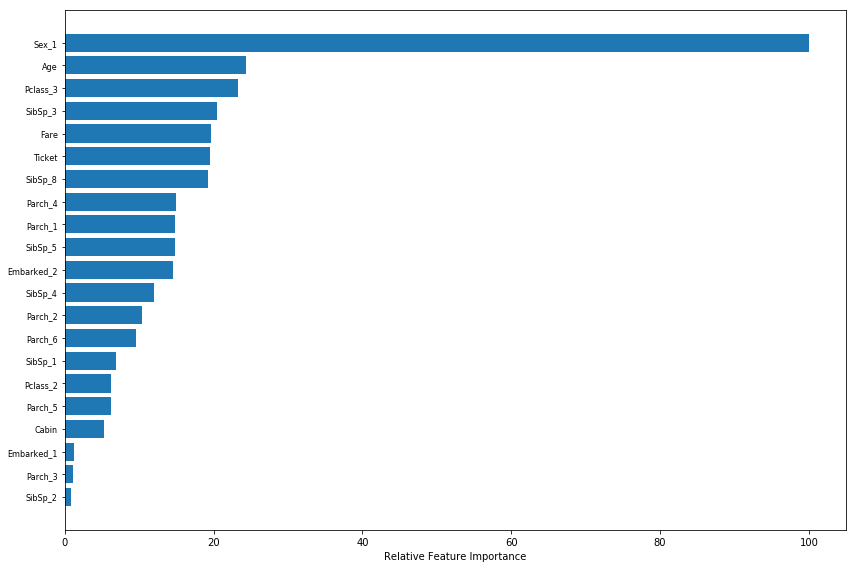

In [66]:
lr_oversampled = TrainModel(LogisticRegressionCV(**params), X_train_oversampled, y_train_oversampled, 
                            X_test_scaled, y_test, need_cont_vars=False, plot_importances=True).train_traditional_ML_model()

### Plot decision function using oversampling

In [67]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [68]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X['Sex_1'].min() - 1, X['Sex_1'].max() + 1
    y_min, y_max = X['Age'].min() - 1, X['Age'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, alpha=0.4)
    ax.scatter(X['Sex_1'], X['Age'], alpha=0.8, c=y, edgecolor='k')

In [69]:
clf = LogisticRegressionCV(**params).fit(X_train_oversampled.iloc[:, 0:2], y_train_oversampled.ravel())

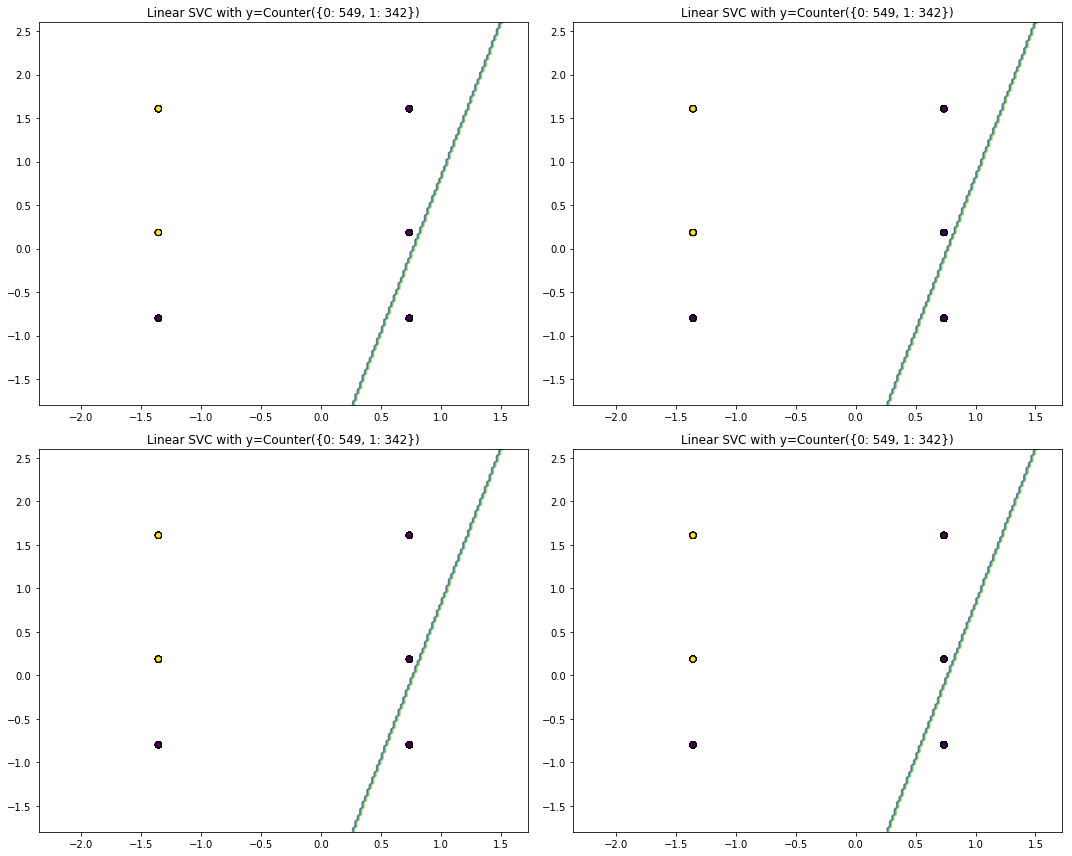

In [70]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    plot_decision_function(X_train_oversampled, y_train_oversampled, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))
fig.tight_layout()


### Try XGBoost

Train Accuracy: 0.8338323353293413
Test Accuracy: 0.7668161434977578
Train F1: 0.8393431559219866
Test F1: 0.7826711535036744
Train:                    pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.82      0.87      0.87      0.84      0.71       473
          1       0.66      0.87      0.82      0.75      0.84      0.72       195

avg / total       0.86      0.83      0.86      0.84      0.84      0.71       668

Test:                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.75      0.83      0.83      0.79      0.61       171
          1       0.50      0.83      0.75      0.62      0.79      0.62        52

avg / total       0.83      0.77      0.81      0.78      0.79      0.62       223



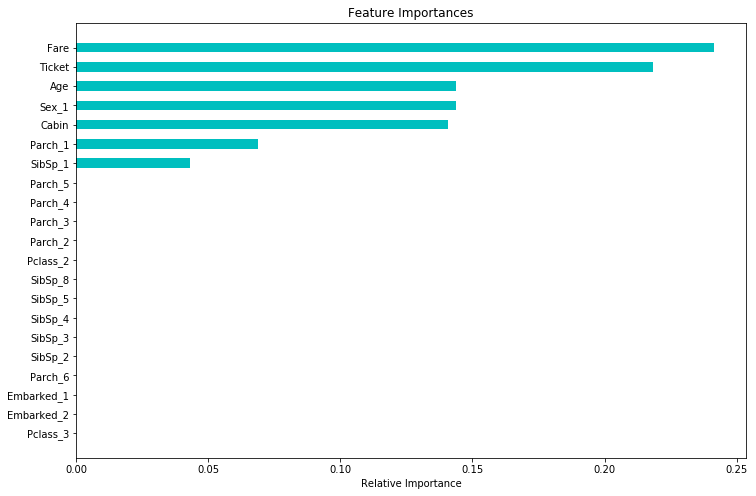

In [71]:
params = {'learning_rate':.01, 'n_jobs':32, 'max_depth':3}
xgbc = TrainModel(XGBClassifier(**params).fit(X_train_scaled, y_train), 
                X_train_scaled, y_train, X_test_scaled, y_test, 
                need_cont_vars=False, plot_importances=True).train_traditional_ML_model()


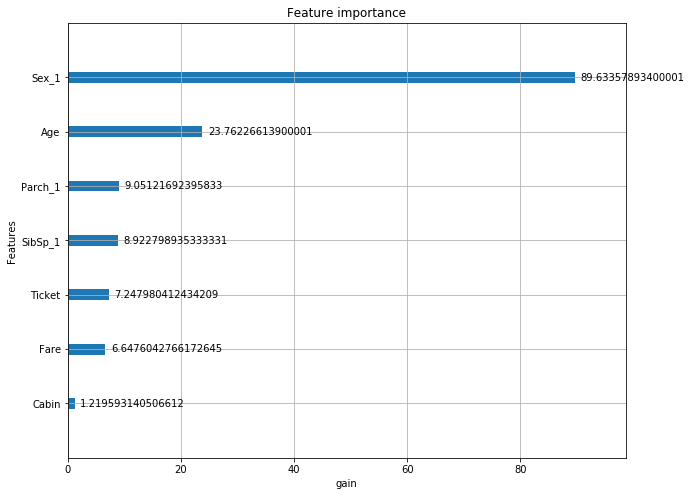

In [72]:
import xgboost as xgb

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgbc, importance_type='gain', xlabel='gain', ax=ax)
plt.show()

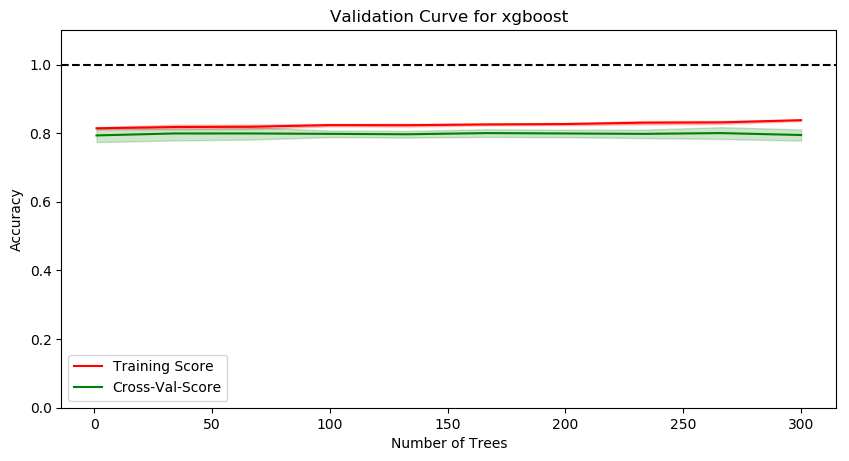

Best CV Result:  0.8002549483347501 266


In [73]:
n_estimators_range = np.linspace(1,300,10).astype('int')

train_scores, test_scores = validation_curve(estimator=XGBClassifier(n_jobs=32, learning_rate=.01),
                                             X=X, y=y,
                                             param_name='n_estimators',
                                             param_range = n_estimators_range,
                                             cv=5,
                                             n_jobs=-1,
                                             scoring='accuracy')



train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,5), dpi=100)

plt.title('Validation Curve for xgboost')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)

plt.plot(n_estimators_range, train_scores_mean, label='Training Score', color='r')
plt.plot(n_estimators_range, test_scores_mean, label='Cross-Val-Score', color='g')

plt.fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=.2, color='r')
plt.fill_between(n_estimators_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=.2, color='g')

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print('Best CV Result: ', test_scores_mean[i], n_estimators_range[i])

XGBoost starts to overfit quicker

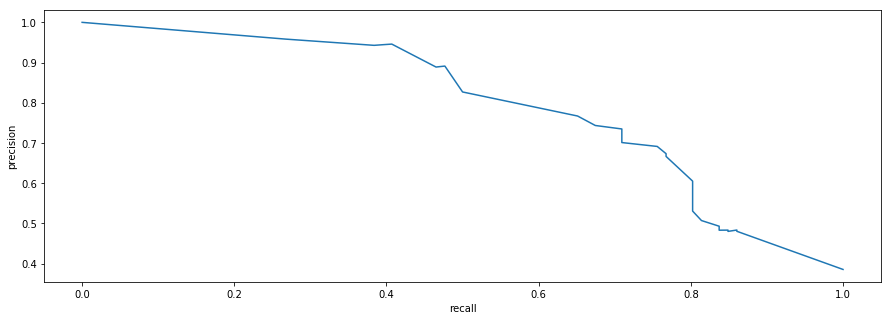

In [74]:
y_score_xgbc = xgbc.predict_proba(X_test_scaled)[:, 1]

precision, recall, threshold = precision_recall_curve(y_test, y_score_xgbc)

fig = plt.gcf()
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
fig.set_size_inches((15, 5))
plt.show()

Explained variation per principal component: [0.12901516 0.08006076]
Train PCA Accuracy: 0.7564870259481038
Test PCA Accuracy: 0.7365269461077845
Train PCA F1: 0.5960264900662251
Test PCA F1: 0.5769230769230769


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=32, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

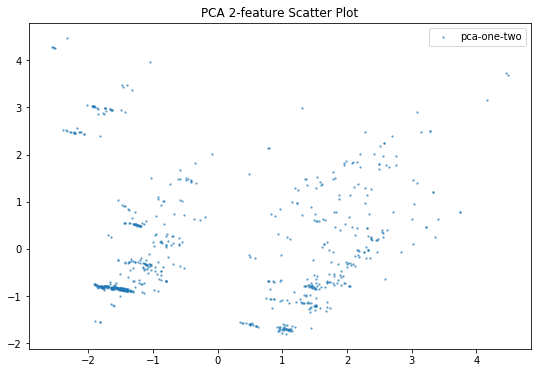

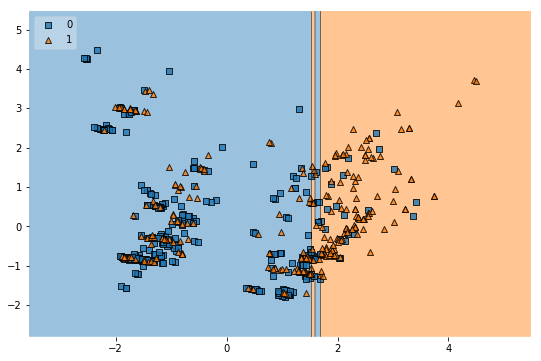

In [75]:
plot_decision_boundary_pca(X_train_scaled, y_train, XGBClassifier(**params))

It's clear the PCA transformation loses a lot of information, but it helps with visualization

In [76]:
X_test_unseen = pd.DataFrame(scaler.transform(df_test), columns=X_test.columns)

In [77]:
X_test_unseen.isnull().sum()[X_test_unseen.isnull().sum()>0]

Series([], dtype: int64)

In [78]:
lr_pred = pd.Series(lr.predict(X_test_unseen), name='Survived')
lr_pred.head()

0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64

In [79]:
df_test.isnull().sum()

Age           0
Ticket        0
Fare          0
Cabin         0
SibSp_1       0
SibSp_2       0
SibSp_3       0
SibSp_4       0
SibSp_5       0
SibSp_8       0
Parch_1       0
Parch_2       0
Parch_3       0
Parch_4       0
Parch_5       0
Parch_6       0
Sex_1         0
Embarked_1    0
Embarked_2    0
Pclass_2      0
Pclass_3      0
dtype: int64

#### Run a chi2 test on the predictions to see if they're good

In [80]:
lr_pred = lr.predict(X_train_scaled)
pred_0s = len(lr_pred[lr_pred==0])
pred_1s = len(lr_pred[lr_pred==1])

dof = len(lr_pred-1) # degrees of freedom

ev_0 = y.value_counts()[0]
ev_1 = y.value_counts()[1]

chi2 = (pred_0s - ev_0)**2 / ev_0 + (pred_1s - ev_1)**2 / ev_1
chi2

59.64116575591986

A value of 59.6 is significantly less than the alpha value of .01 in the chi2 table, so we fail to reject our null hypothesis that our predicted values are statistically similar to the expected values. Basically, the predictions look good according to the chi2 test.

#### Lets do one more chi2 on the xgboost classifier

In [81]:
xgbc_pred = xgbc.predict(X_train_scaled)
pred_0s = len(xgbc_pred[xgbc_pred==0])
pred_1s = len(xgbc_pred[xgbc_pred==1])

dof = len(xgbc_pred-1) # degrees of freedom

ev_0 = y.value_counts()[0]
ev_1 = y.value_counts()[1]

chi2 = (pred_0s - ev_0)**2 / ev_0 + (pred_1s - ev_1)**2 / ev_1
chi2

73.70515770300067

Again a similar number to logistic regression. We fail to reject the null hypothesis.

### Train SVM - can be very predictive if properly tuned

In [82]:
# param_dist = {'C':[0.001, 0.01, 0.1, 1, 10],
#               'kernel':['rbf', 'linear', 'poly'],
#               'gamma':['scale', 0.001, 0.01, 0.1, 1, 10]}

# svm_rs = RandomizedSearchCV(SVC(),
#                       param_distributions=param_dist,
#                       cv=5, n_iter=10,
#                       scoring='accuracy').fit(X_train_scaled, y_train)
# svm_rs.best_params_

In [85]:
svm_rs = TrainModel(SVC(C=10, gamma='scale', kernel='rbf'), X_train_scaled, y_train, 
                    X_test_scaled, y_test, need_cont_vars=False, plot_importances=False).train_traditional_ML_model()

Train Accuracy: 0.8697604790419161
Test Accuracy: 0.7443946188340808
Train F1: 0.8711858395514063
Test F1: 0.7490549233753129
Train:                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.87      0.87      0.90      0.87      0.76       437
          1       0.78      0.87      0.87      0.82      0.87      0.75       231

avg / total       0.88      0.87      0.87      0.87      0.87      0.75       668

Test:                    pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.77      0.70      0.80      0.73      0.54       150
          1       0.59      0.70      0.77      0.64      0.73      0.53        73

avg / total       0.76      0.74      0.72      0.75      0.73      0.54       223



SVM takes a long time to tune, but can yield great results. Without much tuning it is overfitting, and does even more poorly without normalization.

#### Save file for submission

In [95]:
lr_pred = pd.Series(lr.predict(X_test_unseen), name='Survived')
lr_solution = pd.concat([pd.DataFrame(passenger_id_test, columns=['PassengerId']), 
                           pd.DataFrame(lr_pred, columns=['Survived'])], axis=1).set_index('PassengerId')
lr_solution.to_csv('/home/melgazar9/Documents/lr-titanic.csv')

In [96]:
xgbc_pred = pd.Series(xgbc.predict(X_test_unseen), name='Survived')
xgbc_solution = pd.concat([pd.DataFrame(passenger_id_test, columns=['PassengerId']), 
                           pd.DataFrame(xgbc_pred, columns=['Survived'])], axis=1).set_index('PassengerId')
xgbc_solution.to_csv('/home/melgazar9/Documents/xgbc-titanic.csv')